In [3]:
import json
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import numpy as np

def analyze_detection_distribution(json_file_path):
    """
    Analyze the distribution of text detection instances from the JSON results file.
    
    Args:
        json_file_path (str): Path to the detection results JSON file
    """
    # Load the JSON file
    with open(json_file_path, 'r') as f:
        data = json.load(f)
    
    # Convert the images data to a DataFrame for easier analysis
    images_df = pd.DataFrame(data['images'])
    
    # Basic statistics
    total_images = len(images_df)
    images_with_detections = len(images_df[images_df['instances'] > 0])
    detection_rate = images_with_detections / total_images * 100
    
    print(f"=== DETECTION STATISTICS ===")
    print(f"Total images processed: {total_images}")
    print(f"Images with at least one detection: {images_with_detections} ({detection_rate:.2f}%)")
    print(f"Images with no detections: {total_images - images_with_detections} ({100 - detection_rate:.2f}%)")
    
    # Instance count statistics
    max_instances = images_df['instances'].max()
    avg_instances = images_df['instances'].mean()
    median_instances = images_df['instances'].median()
    
    print(f"\n=== INSTANCE COUNT STATISTICS ===")
    print(f"Maximum instances in a single image: {max_instances}")
    print(f"Average instances per image: {avg_instances:.2f}")
    print(f"Median instances per image: {median_instances:.1f}")
    
    # Create visualizations
    
    # 1. Histogram of instance counts
    plt.figure(figsize=(12, 6))
    sns.histplot(data=images_df, x='instances', kde=False, bins=20)
    plt.title('Distribution of Text Instances per Image')
    plt.xlabel('Number of Instances')
    plt.ylabel('Number of Images')
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.savefig('instance_histogram.png')
    plt.close()
    
    # 2. Pie chart: Images with vs. without detections
    plt.figure(figsize=(8, 8))
    labels = ['No detections', 'With detections']
    sizes = [total_images - images_with_detections, images_with_detections]
    colors = ['lightcoral', 'lightgreen']
    plt.pie(sizes, labels=labels, autopct='%1.1f%%', colors=colors, startangle=90)
    plt.axis('equal')
    plt.title('Proportion of Images With vs. Without Text Detections')
    plt.savefig('detection_pie.png')
    plt.close()
    
    # 3. Bar chart for small instance counts (0-10)
    max_to_display = min(10, max_instances)
    small_counts = images_df[images_df['instances'] <= max_to_display]['instances'].value_counts().sort_index()
    
    plt.figure(figsize=(12, 6))
    sns.barplot(x=small_counts.index, y=small_counts.values)
    plt.title(f'Distribution of Images with 0-{max_to_display} Instances')
    plt.xlabel('Number of Instances')
    plt.ylabel('Number of Images')
    plt.xticks(range(max_to_display + 1))
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.savefig('small_instance_counts.png')
    plt.close()
    
    # 4. Grouped instance counts
    bins = [0, 1, 2, 5, 10, 20, 50, float('inf')]
    labels = ['0', '1', '2-4', '5-9', '10-19', '20-49', '50+']
    images_df['instance_group'] = pd.cut(images_df['instances'], bins=bins, labels=labels, right=False)
    group_counts = images_df['instance_group'].value_counts().sort_index()
    
    plt.figure(figsize=(12, 6))
    sns.barplot(x=group_counts.index, y=group_counts.values)
    plt.title('Images Grouped by Number of Text Instances')
    plt.xlabel('Number of Instances')
    plt.ylabel('Number of Images')
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    
    # Add count labels on top of each bar
    for i, count in enumerate(group_counts.values):
        plt.text(i, count + (max(group_counts.values) * 0.01), 
                 str(count), ha='center', va='bottom')
    
    plt.savefig('instance_groups.png')
    plt.close()
    
    print("\n=== INSTANCE GROUPS ===")
    for group, count in group_counts.items():
        print(f"{group} instances: {count} images ({count/total_images*100:.2f}%)")
    
    # 5. Top images with most detections
    top_n = min(10, len(images_df))
    top_images = images_df.nlargest(top_n, 'instances')
    
    print(f"\n=== TOP {top_n} IMAGES WITH MOST DETECTIONS ===")
    for i, (_, row) in enumerate(top_images.iterrows(), 1):
        print(f"{i}. {row['file_name']}: {row['instances']} instances (size: {row['width']}x{row['height']})")
    
    print("\nAnalysis complete! Visualization files saved.")
    return images_df

In [4]:
json_file_path = "sa_000000/text_detection_results.json"  # Change this to your file path
df = analyze_detection_distribution(json_file_path)

=== DETECTION STATISTICS ===
Total images processed: 11186
Images with at least one detection: 6171 (55.17%)
Images with no detections: 5015 (44.83%)

=== INSTANCE COUNT STATISTICS ===
Maximum instances in a single image: 100
Average instances per image: 3.43
Median instances per image: 1.0

=== INSTANCE GROUPS ===
0 instances: 5015 images (44.83%)
1 instances: 1742 images (15.57%)
2-4 instances: 2177 images (19.46%)
5-9 instances: 1216 images (10.87%)
10-19 instances: 677 images (6.05%)
20-49 instances: 290 images (2.59%)
50+ instances: 69 images (0.62%)

=== TOP 10 IMAGES WITH MOST DETECTIONS ===
1. sa_5547.jpg: 100 instances (size: 2248x1500)
2. sa_6296.jpg: 100 instances (size: 2028x1500)
3. sa_6133.jpg: 100 instances (size: 2247x1500)
4. sa_7330.jpg: 100 instances (size: 2249x1500)
5. sa_4884.jpg: 100 instances (size: 2250x1500)
6. sa_4867.jpg: 100 instances (size: 2000x1500)
7. sa_8478.jpg: 100 instances (size: 2000x1500)
8. sa_10430.jpg: 100 instances (size: 2250x1500)
9. sa_550

In [6]:
# Find 5 examples of images with 5-9 text instances
medium_instance_examples = df[(df['instances'] >= 5) & (df['instances'] < 10)].sample(5, random_state=42)
print("=== EXAMPLES WITH 5-9 INSTANCES ===")
for _, row in medium_instance_examples.iterrows():
    print(f"File: {row['file_name']} - {row['instances']} instances ({row['width']}x{row['height']})")

# Find 5 examples of images with 10-19 text instances
high_instance_examples = df[(df['instances'] >= 10) & (df['instances'] < 20)].sample(5, random_state=42)
print("\n=== EXAMPLES WITH 10-19 INSTANCES ===")
for _, row in high_instance_examples.iterrows():
    print(f"File: {row['file_name']} - {row['instances']} instances ({row['width']}x{row['height']})")
    

=== EXAMPLES WITH 5-9 INSTANCES ===
File: sa_6609.jpg - 5 instances (2250x1500)
File: sa_4021.jpg - 5 instances (1500x2250)
File: sa_8656.jpg - 5 instances (1500x1998)
File: sa_35.jpg - 7 instances (2037x1500)
File: sa_8924.jpg - 6 instances (2250x1500)

=== EXAMPLES WITH 10-19 INSTANCES ===
File: sa_1401.jpg - 10 instances (2247x1500)
File: sa_9456.jpg - 13 instances (2006x1500)
File: sa_1366.jpg - 16 instances (2250x1500)
File: sa_944.jpg - 15 instances (1500x2250)
File: sa_606.jpg - 13 instances (2250x1500)


In [8]:
import os
import shutil

# Define directories
source_dir = "/media/dataset2/hyunbin/SA-1B/sa_000000"  # Update this to your actual image directory
dest_base_dir = "sa_000000_examples"  # Base directory for example images

# Create destination directories
os.makedirs(os.path.join(dest_base_dir, "5-9_instances"), exist_ok=True)
os.makedirs(os.path.join(dest_base_dir, "10-19_instances"), exist_ok=True)

# Copy 5-9 instance examples
print("\n=== COPYING EXAMPLES WITH 5-9 INSTANCES ===")
for _, row in medium_instance_examples.iterrows():
    source_file = os.path.join(source_dir, row['file_name'])
    dest_file = os.path.join(dest_base_dir, "5-9_instances", row['file_name'])
    if os.path.exists(source_file):
        shutil.copy2(source_file, dest_file)
        print(f"Copied: {row['file_name']} - {row['instances']} instances")
    else:
        print(f"Warning: Source file not found: {source_file}")

# Copy 10-19 instance examples
print("\n=== COPYING EXAMPLES WITH 10-19 INSTANCES ===")
for _, row in high_instance_examples.iterrows():
    source_file = os.path.join(source_dir, row['file_name'])
    dest_file = os.path.join(dest_base_dir, "10-19_instances", row['file_name'])
    if os.path.exists(source_file):
        shutil.copy2(source_file, dest_file)
        print(f"Copied: {row['file_name']} - {row['instances']} instances")
    else:
        print(f"Warning: Source file not found: {source_file}")

print(f"\nFiles copied to directories under '{dest_base_dir}'")


=== COPYING EXAMPLES WITH 5-9 INSTANCES ===
Copied: sa_6609.jpg - 5 instances
Copied: sa_4021.jpg - 5 instances
Copied: sa_8656.jpg - 5 instances
Copied: sa_35.jpg - 7 instances
Copied: sa_8924.jpg - 6 instances

=== COPYING EXAMPLES WITH 10-19 INSTANCES ===
Copied: sa_1401.jpg - 10 instances
Copied: sa_9456.jpg - 13 instances
Copied: sa_1366.jpg - 16 instances
Copied: sa_944.jpg - 15 instances
Copied: sa_606.jpg - 13 instances

Files copied to directories under 'sa_000000_examples'


KeyboardInterrupt: 

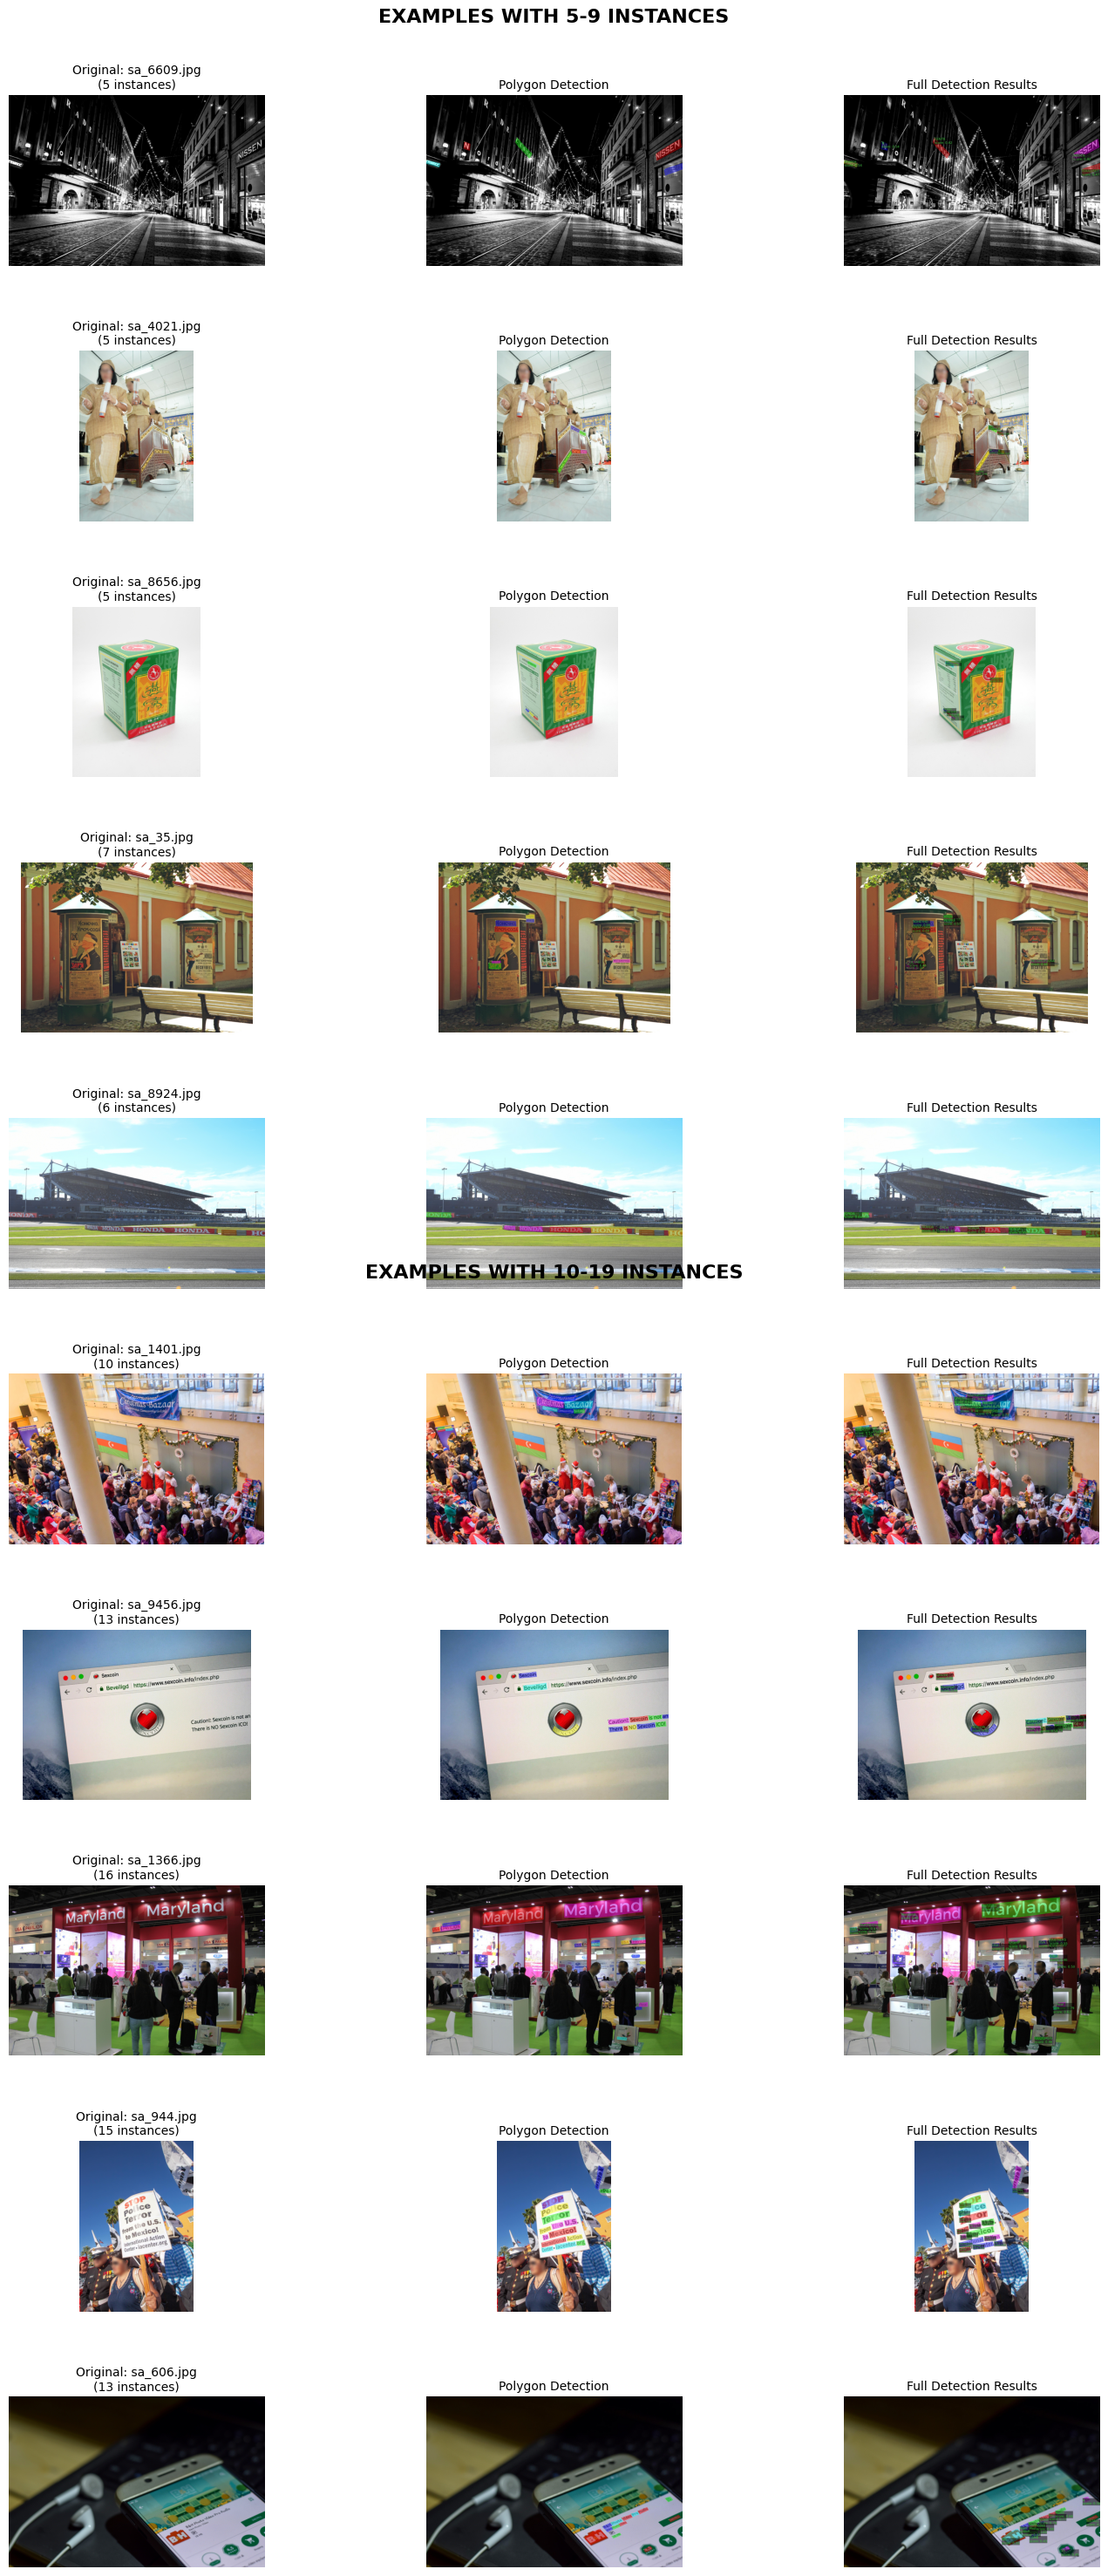

In [10]:
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image
import os

# Define directories
original_dir = "sa_000000_examples"
polygon_dir = "sa_000000_only_polygons"
full_results_dir = "sa_000000"

# Image filenames
category1_files = ["sa_6609.jpg", "sa_4021.jpg", "sa_8656.jpg", "sa_35.jpg", "sa_8924.jpg"]  # 5-9 instances
category2_files = ["sa_1401.jpg", "sa_9456.jpg", "sa_1366.jpg", "sa_944.jpg", "sa_606.jpg"]  # 10-19 instances

# Instance counts
category1_counts = [5, 5, 5, 7, 6]
category2_counts = [10, 13, 16, 15, 13]

# Create a figure with multiple subplots
fig = plt.figure(figsize=(15, 30))

# Function to display image triplet
def display_triplet(file_idx, category_idx, row_idx, instance_count):
    filename = category1_files[file_idx] if category_idx == 1 else category2_files[file_idx]
    
    # Original image
    plt.subplot(10, 3, 3*row_idx + 1)
    try:
        img = np.array(Image.open(os.path.join(original_dir, filename)))
        plt.imshow(img)
        plt.title(f"Original: {filename}\n({instance_count} instances)", fontsize=10)
    except Exception as e:
        plt.text(0.5, 0.5, f"Error loading image:\n{str(e)}", ha='center', va='center', transform=plt.gca().transAxes)
    plt.axis('off')
    
    # Polygon only
    plt.subplot(10, 3, 3*row_idx + 2)
    try:
        img = np.array(Image.open(os.path.join(polygon_dir, filename)))
        plt.imshow(img)
        plt.title("Polygon Detection", fontsize=10)
    except Exception as e:
        plt.text(0.5, 0.5, f"Error loading image:\n{str(e)}", ha='center', va='center', transform=plt.gca().transAxes)
    plt.axis('off')
    
    # Full results
    plt.subplot(10, 3, 3*row_idx + 3)
    try:
        img = np.array(Image.open(os.path.join(full_results_dir, filename)))
        plt.imshow(img)
        plt.title("Full Detection Results", fontsize=10)
    except Exception as e:
        plt.text(0.5, 0.5, f"Error loading image:\n{str(e)}", ha='center', va='center', transform=plt.gca().transAxes)
    plt.axis('off')

# Add category title: 5-9 instances
fig.text(0.5, 0.98, "EXAMPLES WITH 5-9 INSTANCES", ha='center', va='center', fontsize=16, weight='bold')

# Display category 1 images (5-9 instances)
for i in range(5):
    display_triplet(i, 1, i, category1_counts[i])

# Add category title: 10-19 instances
fig.text(0.5, 0.5, "EXAMPLES WITH 10-19 INSTANCES", ha='center', va='center', fontsize=16, weight='bold')

# Display category 2 images (10-19 instances)
for i in range(5):
    display_triplet(i, 2, i+5, category2_counts[i])

# Adjust spacing
plt.tight_layout(rect=[0, 0, 1, 0.95])  # Leave room for category titles
plt.subplots_adjust(top=0.95, hspace=0.5)

# Save high-resolution figure
plt.savefig("detection_examples_comparison.png", dpi=300, bbox_inches='tight')
plt.show()

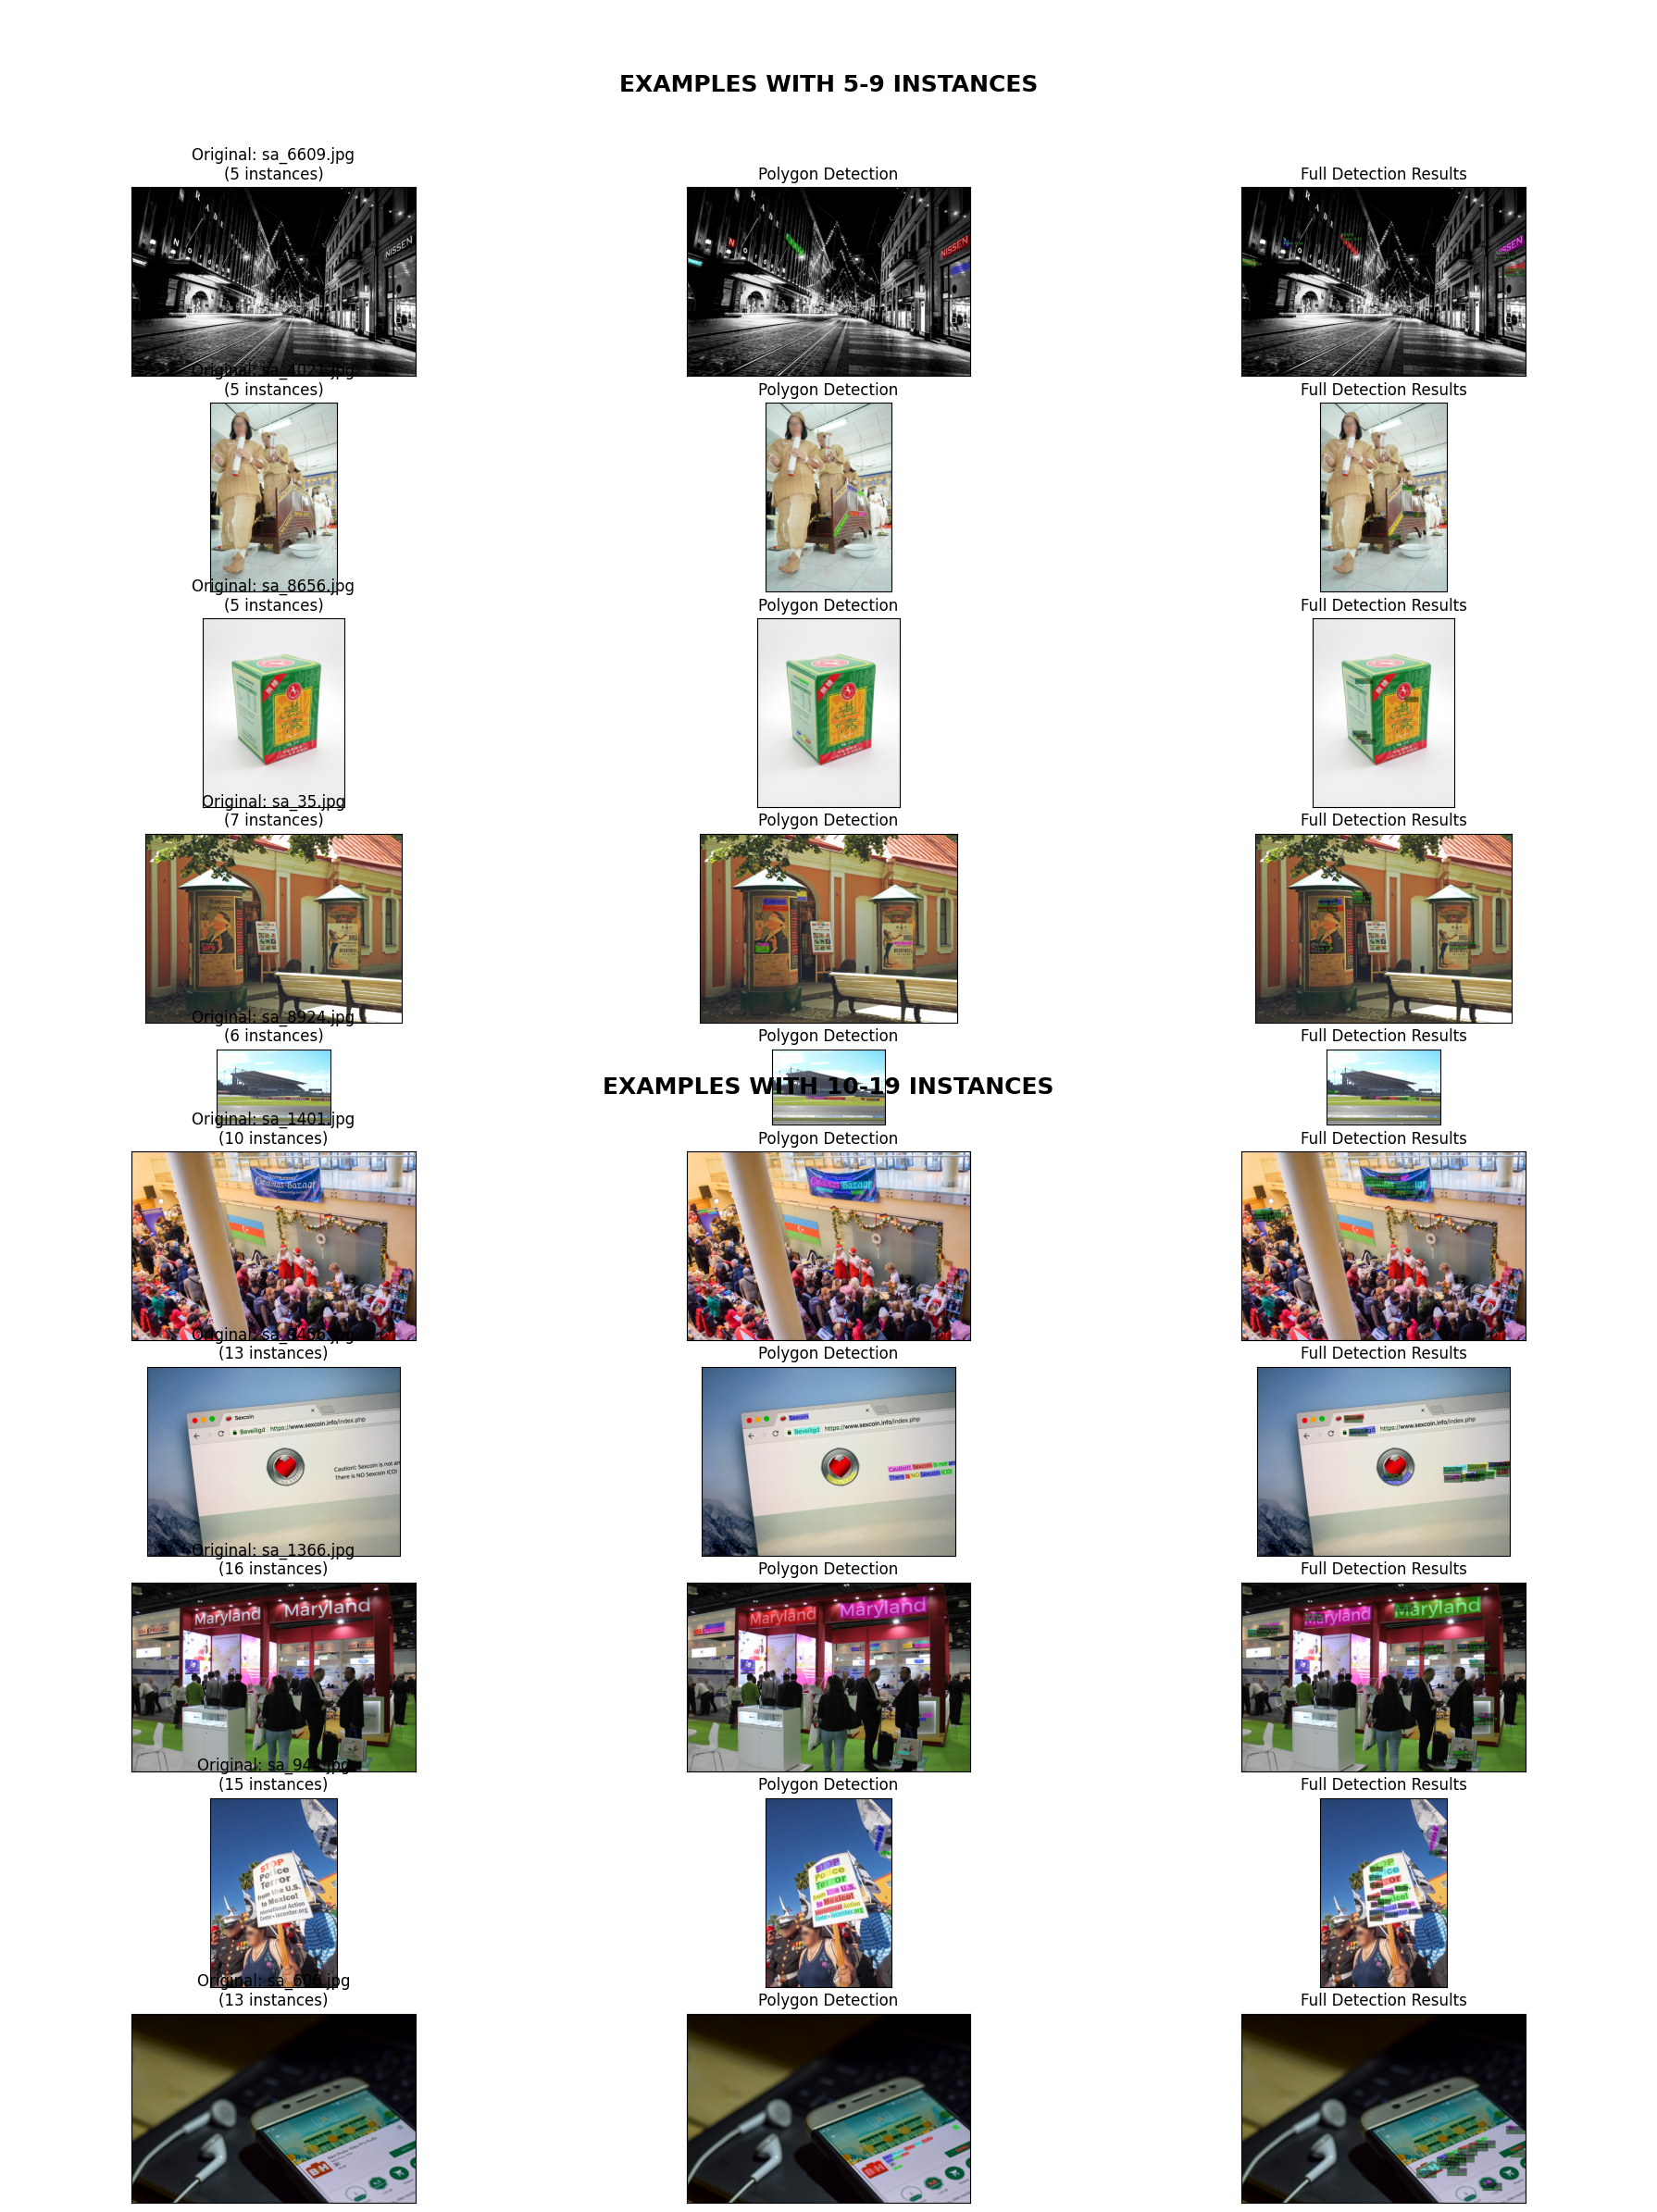

In [11]:
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image
import os
import matplotlib.gridspec as gridspec

# Define directories
original_dir = "sa_000000_examples"
polygon_dir = "sa_000000_only_polygons"
full_results_dir = "sa_000000"

# Image filenames
category1_files = ["sa_6609.jpg", "sa_4021.jpg", "sa_8656.jpg", "sa_35.jpg", "sa_8924.jpg"]  # 5-9 instances
category2_files = ["sa_1401.jpg", "sa_9456.jpg", "sa_1366.jpg", "sa_944.jpg", "sa_606.jpg"]  # 10-19 instances

# Instance counts
category1_counts = [5, 5, 5, 7, 6]
category2_counts = [10, 13, 16, 15, 13]

# Create a figure with custom grid layout
fig = plt.figure(figsize=(18, 24))

# Create grid with 11 rows (5 for cat1, 1 for header, 5 for cat2)
# 3 columns (original, polygon, full)
gs = gridspec.GridSpec(11, 3, height_ratios=[0.8, 1, 1, 1, 1, 0.4, 1, 1, 1, 1, 1])

# Add title for first category
ax_title1 = fig.add_subplot(gs[0, :])
ax_title1.text(0.5, 0.5, "EXAMPLES WITH 5-9 INSTANCES", 
              ha='center', va='center', fontsize=18, weight='bold')
ax_title1.axis('off')

# Function to display image
def display_image(row, col, filename, dir_path, title=None):
    ax = fig.add_subplot(gs[row, col])
    try:
        img = Image.open(os.path.join(dir_path, filename))
        ax.imshow(np.array(img))
        if title:
            ax.set_title(title, fontsize=12)
    except Exception as e:
        ax.text(0.5, 0.5, f"Error loading image:\n{str(e)}", 
               ha='center', va='center', transform=ax.transAxes)
    ax.set_xticks([])
    ax.set_yticks([])

# Display first category (5-9 instances)
for i in range(5):
    # Get current filename and instance count
    filename = category1_files[i]
    count = category1_counts[i]
    
    # Row in grid (add 1 to account for title row)
    row = i + 1
    
    # Display triplet
    display_image(row, 0, filename, original_dir, f"Original: {filename}\n({count} instances)")
    display_image(row, 1, filename, polygon_dir, "Polygon Detection")
    display_image(row, 2, filename, full_results_dir, "Full Detection Results")

# Add title for second category
ax_title2 = fig.add_subplot(gs[5, :])
ax_title2.text(0.5, 0.5, "EXAMPLES WITH 10-19 INSTANCES", 
              ha='center', va='center', fontsize=18, weight='bold')
ax_title2.axis('off')

# Display second category (10-19 instances)
for i in range(5):
    # Get current filename and instance count
    filename = category2_files[i]
    count = category2_counts[i]
    
    # Row in grid (add 6 to account for first category + titles)
    row = i + 6
    
    # Display triplet
    display_image(row, 0, filename, original_dir, f"Original: {filename}\n({count} instances)")
    display_image(row, 1, filename, polygon_dir, "Polygon Detection")
    display_image(row, 2, filename, full_results_dir, "Full Detection Results")

# Adjust layout
plt.tight_layout()
plt.subplots_adjust(wspace=0.05, hspace=0.15)  # Reduce spacing between images

# Save high-resolution figure
plt.savefig("detection_examples_comparison.png", dpi=300, bbox_inches='tight')
plt.show()

In [12]:
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image
import os

# Define directories
original_dir = "sa_000000_examples"
polygon_dir = "sa_000000_only_polygons"
full_results_dir = "sa_000000"

# Create output directory for comparison images
output_dir = "image_comparisons"
os.makedirs(output_dir, exist_ok=True)

# Image filenames and instance counts
image_data = [
    # 5-9 instances
    {"filename": "sa_6609.jpg", "count": 5, "category": "5-9"},
    {"filename": "sa_4021.jpg", "count": 5, "category": "5-9"},
    {"filename": "sa_8656.jpg", "count": 5, "category": "5-9"},
    {"filename": "sa_35.jpg", "count": 7, "category": "5-9"},
    {"filename": "sa_8924.jpg", "count": 6, "category": "5-9"},
    # 10-19 instances
    {"filename": "sa_1401.jpg", "count": 10, "category": "10-19"},
    {"filename": "sa_9456.jpg", "count": 13, "category": "10-19"},
    {"filename": "sa_1366.jpg", "count": 16, "category": "10-19"},
    {"filename": "sa_944.jpg", "count": 15, "category": "10-19"},
    {"filename": "sa_606.jpg", "count": 13, "category": "10-19"}
]

def create_comparison(image_info):
    """Create a side-by-side comparison image for a single case"""
    filename = image_info["filename"]
    instance_count = image_info["count"]
    category = image_info["category"]
    
    # Create figure
    fig, axes = plt.subplots(1, 3, figsize=(15, 6))
    fig.suptitle(f"Image: {filename} ({instance_count} instances - {category} category)", fontsize=16)
    
    # Load and display original image
    try:
        original_img = Image.open(os.path.join(original_dir, filename))
        axes[0].imshow(np.array(original_img))
        axes[0].set_title("Original Image", fontsize=14)
        axes[0].axis('off')
    except Exception as e:
        axes[0].text(0.5, 0.5, f"Error loading image: {e}", ha='center', va='center')
    
    # Load and display polygon detection
    try:
        polygon_img = Image.open(os.path.join(polygon_dir, filename))
        axes[1].imshow(np.array(polygon_img))
        axes[1].set_title("Polygon Detection", fontsize=14)
        axes[1].axis('off')
    except Exception as e:
        axes[1].text(0.5, 0.5, f"Error loading image: {e}", ha='center', va='center')
    
    # Load and display full results
    try:
        results_img = Image.open(os.path.join(full_results_dir, filename))
        axes[2].imshow(np.array(results_img))
        axes[2].set_title("Full Detection Results", fontsize=14)
        axes[2].axis('off')
    except Exception as e:
        axes[2].text(0.5, 0.5, f"Error loading image: {e}", ha='center', va='center')
    
    # Save comparison image
    output_filename = os.path.join(output_dir, f"comparison_{filename[:-4]}.png")
    plt.tight_layout()
    plt.savefig(output_filename, dpi=300, bbox_inches='tight')
    plt.close()
    
    return output_filename

# Generate all comparison images
for image_info in image_data:
    output_file = create_comparison(image_info)
    print(f"Created comparison for {image_info['filename']} → {os.path.basename(output_file)}")

print(f"\nAll comparison images saved to the '{output_dir}' directory")

Created comparison for sa_6609.jpg → comparison_sa_6609.png
Created comparison for sa_4021.jpg → comparison_sa_4021.png
Created comparison for sa_8656.jpg → comparison_sa_8656.png
Created comparison for sa_35.jpg → comparison_sa_35.png
Created comparison for sa_8924.jpg → comparison_sa_8924.png
Created comparison for sa_1401.jpg → comparison_sa_1401.png
Created comparison for sa_9456.jpg → comparison_sa_9456.png
Created comparison for sa_1366.jpg → comparison_sa_1366.png
Created comparison for sa_944.jpg → comparison_sa_944.png
Created comparison for sa_606.jpg → comparison_sa_606.png

All comparison images saved to the 'image_comparisons' directory
